In [1]:
import pandas as pd
import numpy as np

RAMDOM_STATE = 11

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";") #Leitura dos dados para o pandas

In [3]:
df.set_index('id',inplace=True) #Transformando a coluna id no indice da tabela

#Observem que a classe esta separada em duas colunas então devemos concatenadas para formar uma coluna só chamada classe
df['classe'] = df['tipo_lampada'].str.replace(" ", "") + df['potencia'].astype(str) 

In [4]:
# Lista de Indices
FOURIER = ['df01', 'df02', 'df03', 'df04','df05', 'df06', 'df07', 'df08', 'df09', 'df10']
HU = ['i1', 'i2', 'i3', 'i4','i5', 'i6', 'i7']
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']
ALL = FOURIER + HU + HARALICK
MY = HU

df[ALL] = df[ALL].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)

X = df[MY]
Y = df['classe']

In [5]:
X.to_csv('X.csv', index=False)
X

,i1,i2,i3,i4,i5,i6,i7
id,,,,,,,
355,0.168084,0.000615,0.000131,5.717751e-05,3.808159e-09,-1.417337e-06,3.153370e-09
356,0.164507,0.001087,0.000043,1.011576e-08,-5.395931e-15,-6.859661e-11,3.907229e-15
357,0.163434,0.000767,0.000042,5.386911e-09,-8.512721e-16,1.025674e-10,-2.417528e-15
358,0.194681,0.000430,0.000351,9.433074e-08,-4.535061e-13,-1.859019e-09,2.981211e-13
359,0.178424,0.000125,0.000788,4.385479e-04,2.487489e-07,-4.861444e-06,6.771579e-08
...,...,...,...,...,...,...,...
656,0.171602,0.002627,0.000159,3.640445e-06,8.760447e-11,1.822845e-07,-3.202402e-12
657,0.172655,0.000261,0.000068,1.504726e-06,1.367720e-11,-6.451751e-09,6.681615e-12
658,0.177559,0.000174,0.000013,3.194222e-06,-5.618219e-12,3.521780e-08,1.995746e-11


In [6]:
results_df = pd.DataFrame(columns=['Método', 'Média', 'Desvio padrão', 'Limite inf.', 'Limite sup.'])

### zeroR

In [7]:
from sklearn.model_selection import cross_val_predict 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats

zR = DummyClassifier(strategy='most_frequent')

cv_zR = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RAMDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RAMDOM_STATE)

scores_ZR = cross_val_score(zR, X_train, y_train, scoring='accuracy', cv=cv_zR)

inf, sup = stats.norm.interval(0.95, loc=scores_ZR.mean(), scale=scores_ZR.std()/np.sqrt(len(scores_ZR)))

results_df = pd.concat([results_df, pd.DataFrame({'Método': ['ZR'], 'Média': [scores_ZR.mean()], 'Desvio padrão': scores_ZR.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

print(scores_ZR.mean())
print(type(scores_ZR))

0.1563405797101449
<class 'numpy.ndarray'>


In [8]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

def train_models(model, params_grid, name):
    scalar = StandardScaler()
    pipe = Pipeline(steps=[('s',scalar), ('m', model)])

    inner_cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=RAMDOM_STATE)

    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RAMDOM_STATE)

    grid_search = GridSearchCV(pipe, param_grid=params_grid,  scoring='accuracy', cv=inner_cv, n_jobs=-1)

    scores = cross_val_score(grid_search, X, Y.values.ravel(), scoring='accuracy', cv=outer_cv, n_jobs=-1)

    inf, sup = stats.norm.interval(0.95, loc=scores.mean(), scale=scores.std()/np.sqrt(len(scores)))

    local_df = pd.concat([results_df, pd.DataFrame({'Método': [name], 'Média': [scores.mean()], 'Desvio padrão': scores.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

    return local_df, scores

In [9]:
from sklearn.ensemble import BaggingClassifier


bg = BaggingClassifier(n_estimators=3, random_state=RAMDOM_STATE)

params_grid = {
    'm__n_estimators': [3,9,15,21]
    } 

results_df, scores_BA = train_models(bg, params_grid, 'BA')

In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=3, random_state=RAMDOM_STATE)

params_grid = {
    'm__n_estimators': [3,9,15,21]
    }

results_df, scores_AD = train_models(ada, params_grid, 'AD')

In [11]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=RAMDOM_STATE)

params_grid = {
    'm__n_estimators': [3,9,15,21]
}

results_df, scores_RF = train_models(rf, params_grid, 'RF')

In [12]:
results_df

,Método,Média,Desvio padrão,Limite inf.,Limite sup.
0,ZR,0.156341,0.020735,0.148921,0.163761
1,BA,0.461571,0.096206,0.427145,0.495997
2,AD,0.257165,0.027720,0.247246,0.267084
3,RF,0.472797,0.074776,0.446039,0.499555


In [13]:
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.validation import check_X_y
from sklearn.utils import resample
from collections import Counter


class HeterogeneousPooling(BaseEstimator):
    # define o construtor para o classificador
    def __init__(self, n_samples=3):
        self.classifiers = [DecisionTreeClassifier(random_state=RAMDOM_STATE), KNeighborsClassifier(), GaussianNB()]
        self.n_samples = n_samples
        self.trained_classifiers = []

    def fit(self, X, y):
        self.counter = Counter(y)

        for i in range(self.n_samples):
            if i == 0:
                X_train = X
                y_train = y
            else:
                X_train, y_train = resample(X, y, replace=True, random_state=RAMDOM_STATE)

            self.train_classifiers(X_train, y_train)
        return self
    
    def train_classifiers(self, X, y):
        
        for classifier in self.classifiers:
            classifier.fit(X, y.ravel())
            self.trained_classifiers.append(classifier)

    def predict(self, X_test):
        predictions = []

        class_frequence = Y.value_counts().index.tolist()

        for _, row in X_test.iterrows():
            predictions.append(self.unique_predict(row, class_frequence))

        return predictions

    def unique_predict(self, X, class_frequence):
        predictions = {}

        for classifier in self.trained_classifiers:
            pred = classifier.predict(X)
            print(pred)
            if pred[0] not in predictions:
                predictions[pred[0]] = 1
            else:
                predictions[pred[0]] += 1
        
        # verificar se existe mais de uma classe com a mesma quantidade de votos
        max_votes = max(predictions.values())
        max_classes = [k for k, v in predictions.items() if v == max_votes]

        if len(max_classes) > 1:
            # se sim, retornar a classe mais frequente na base de treino
            return self.counter.most_common(1)[0][0]
        else:
            # se não, retornar a classe mais votada
            return max_classes[0]
        

In [18]:


hp = HeterogeneousPooling()

params_grid = {
    'm__n_samples': [1,3,5,7]
}

def train_models1(model, params_grid, name):
    scalar = StandardScaler()
    pipe = Pipeline(steps=[('s',scalar), ('m', model)])

    inner_cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=RAMDOM_STATE)

    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RAMDOM_STATE)

    grid_search = GridSearchCV(pipe, param_grid=params_grid,  scoring='accuracy', cv=inner_cv, n_jobs=-1)

    scores = cross_val_score(grid_search, X, Y, scoring='accuracy', cv=outer_cv, n_jobs=-1)
    print(scores)

    inf, sup = stats.norm.interval(0.95, loc=scores.mean(), scale=scores.std()/np.sqrt(len(scores)))

    local_df = pd.concat([results_df, pd.DataFrame({'Método': [name], 'Média': [scores.mean()], 'Desvio padrão': scores.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

    return local_df, scores

results_df, scores_HP = train_models1(hp, params_grid, 'HP')

ValueError: max() arg is an empty sequence

In [ ]:
results_df

,Método,Média,Desvio padrão,Limite inf.,Limite sup.
0,ZR,0.156341,0.020735,0.148921,0.163761
1,BA,0.461571,0.096206,0.427145,0.495997
2,AD,0.257165,0.027720,0.247246,0.267084
3,RF,0.472797,0.074776,0.446039,0.499555
4,HP,NaN,NaN,NaN,NaN
5,HP,NaN,NaN,NaN,NaN
6,HP,NaN,NaN,NaN,NaN
7,HP,NaN,NaN,NaN,NaN
8,HP,NaN,NaN,NaN,NaN
9,HP,NaN,NaN,NaN,NaN


In [ ]:
from scipy import stats 
# ttest and wilcoxon test

scores = [scores_ZR, scores_BA, scores_AD, scores_RF, scores_HP]
models_names = ['ZeroR', 'BG', 'AB', 'RF', 'HP']

qtd_models = 4

comparative_results = {}

for i in range(qtd_models):
    comparative_results[i] = {}
    for j in range(i+1, qtd_models):
        aux = j
        # ttest
        ttest = stats.ttest_rel(scores[i], scores[j])
        # wilcoxon
        wilcoxon = stats.wilcoxon(scores[i], scores[j], method='approx')
        # save results
        comparative_results[i][aux] = {'ttest': ttest[1], 'wilcoxon': wilcoxon[1]}
        # print(models_names[i] + ' x ' + models_names[j])
        # print('ttest: ', comparative_results[i][j]['ttest'])
        # print('wilcoxon: ', comparative_results[i][j]['wilcoxon'])

# for i in range(qtd_models):
#     for j in range(i+1, qtd_models):
#         print(models_names[i] + ' x ' + models_names[j])
#         print('ttest: ', comparative_results[i][j]['ttest'])
#         print('wilcoxon: ', comparative_results[i][j]['wilcoxon'])
        


# tabela com os resultados dos testes, t student no superior e wilcoxon no inferior
table = pd.DataFrame(columns=models_names, index=models_names)

for i in range(qtd_models):
    for j in range(i, qtd_models):
#         # se o index for igual a coluna 
        if i == j:
            table.loc[models_names[i], models_names[j]] = models_names[i]

        else:
            table.loc[models_names[i], models_names[j]] = comparative_results[i][j]['ttest']
            table.loc[models_names[j], models_names[i]] = comparative_results[i][j]['wilcoxon']

table

,ZeroR,BG,AB,RF,HP
ZeroR,ZeroR,0.0,0.0,0.0,NaN
BG,0.000002,BG,0.0,0.38063,NaN
AB,0.000002,0.000002,AB,0.0,NaN
RF,0.000002,0.544308,0.000002,RF,NaN
HP,NaN,NaN,NaN,NaN,NaN


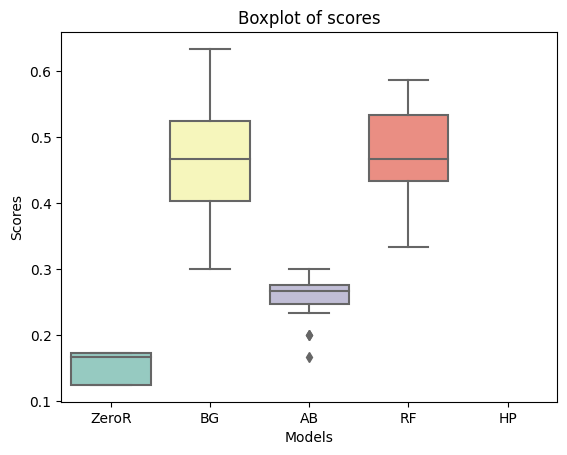

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#box plot of scores 
sns.boxplot(data=scores, palette="Set3").set(xticklabels=models_names)
plt.title('Boxplot of scores')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.savefig('boxplot_scores.png')